# Kalman filter example demo in Python

A Python implementation of the example given in pages 11-15 of "An Introduction to the Kalman Filter" by Greg Welch and Gary Bishop, University of North Carolina at Chapel Hill, Department of Computer Science, TR 95-041, http://www.cs.unc.edu/~welch/kalman/kalmanIntro.html by Andrew D. Straw

In [14]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd 
from scipy.stats import t
plt.rcParams['figure.figsize'] = (10, 8)

## Read the data

We will use the know flights dataset.

In [5]:
data = pd.read_csv('https://raw.githubusercontent.com/mwaskom/seaborn-data/master/flights.csv')
data.head()

,year,month,passengers
0,1949,January,112
1,1949,February,118
2,1949,March,132
3,1949,April,129
4,1949,May,121


As we can see, the dates are separated into 2 columns: year and month. However we need to create a timestamp series to plot the data.

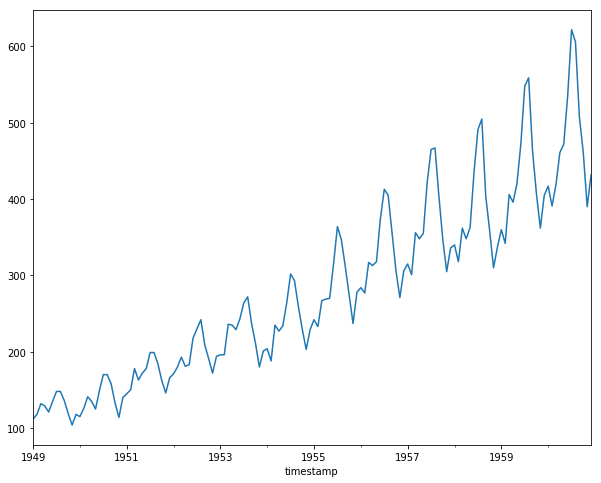

In [18]:
data['timestamp'] = pd.to_datetime(
    data.apply(lambda x: "{}/{}/01".format(x['year'], x['month']), axis=1),
    format="%Y/%B/%d")

data = data.set_index('timestamp').tz_localize('UTC')
_ = data['passengers'].plot()

In [81]:
# intial parameters
z = data['passengers'].fillna(method='ffill')
n_iter = len(z)
size_z = (n_iter, ) # size of array

Q = 1e-5 # process variance

# allocate space for arrays
x_hat = np.zeros(size_z)      # a posteri estimate of x
P = np.zeros(size_z)         # a posteri error estimate
x_hat_m = np.zeros(size_z) # a priori estimate of x
P_m = np.zeros(size_z)    # a priori error estimate
K = np.zeros(size_z)         # gain or blending factor

window = 5
interval = 0.99
rolling_z = z.rolling(window)

R = 1.0/rolling_z.var() # estimate of measurement variance, change to see effect
roll_std = rolling_z.std() # estimate of measurement variance, change to see effect
roll_sum = rolling_z.sum()**2
roll_sum2 = (z**2).rolling(window).sum()
roll_mean = rolling_z.mean()
student_coeff = t.pdf([(1 - interval)/2.0], window - 2)[0]

R.loc[R.isnull()] = 0

In [82]:
# intial guesses
x_hat[0] = z.min()
P[0] = 1.0

for k in range(1,n_iter):
    # time update
    x_hat_m[k] = x_hat[k - 1]
    P_m[k] = P[k-1] + Q

    # measurement update
    K[k] = P_m[k]/(P_m[k] + R[k])
    x_hat[k] = x_hat_m[k] + K[k] * (z[k] - x_hat_m[k])
    P[k] = (1 - K[k]) * P_m[k]

coefficient = student_coeff * roll_std * np.sqrt(1 + 1/window) #+ window * (x_hat - roll_mean) / (window * roll_sum2 - roll_sum))
pred_interval_upper = x_hat + coefficient
pred_interval_lower = x_hat - coefficient

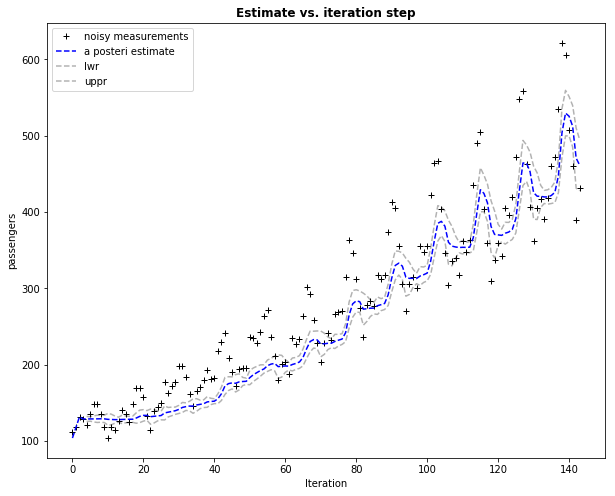

In [83]:
plt.figure()
plt.plot(z.tolist(),'k+',label='noisy measurements')
plt.plot(x_hat,'b--',label='a posteri estimate')
plt.plot(pred_interval_lower.tolist(),'k--',label='lwr', alpha=0.3)
plt.plot(pred_interval_upper.tolist(),'k--',label='uppr', alpha=0.3)
plt.legend()
plt.title('Estimate vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('passengers')

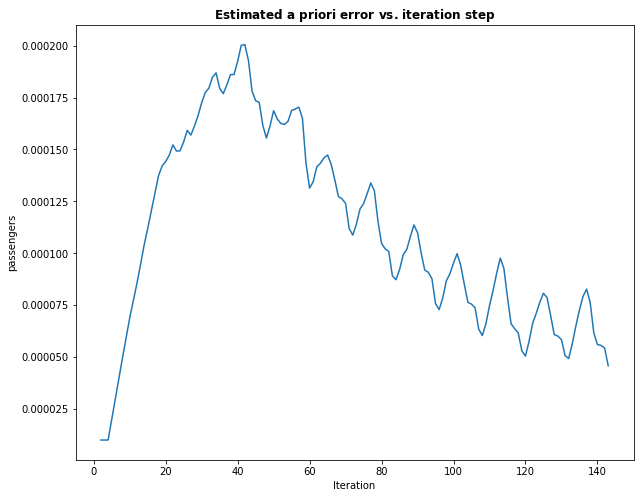

In [84]:
plt.figure()
valid_iter = range(2, n_iter) # P_m not valid at step 0
plt.plot(valid_iter,P_m[2:],label='a priori error estimate')
plt.title('Estimated $\it{\mathbf{a \ priori}}$ error vs. iteration step', fontweight='bold')
plt.xlabel('Iteration')
plt.ylabel('passengers')
plt.show()